In [7]:
# Import Spark NLP
from sparknlp.base import *
from sparknlp.annotator import *
from sparknlp.pretrained import PretrainedPipeline
import sparknlp
import pandas as pd
import sparknlp
from sparknlp.base import *
from sparknlp.annotator import *
from sparknlp.common import *
import numpy as np
from sklearn.model_selection import train_test_split

In [8]:
# Sources of inspiration
# https://towardsdatascience.com/named-entity-recognition-ner-with-bert-in-spark-nlp-874df20d1d77
# https://github.com/JohnSnowLabs/spark-nlp

In [9]:
# Start Spark Session with Spark NLP
spark = sparknlp.start()

In [10]:
#Open the training data in Pandas 
df = pd.read_csv('train.csv')
df

,Label_Name,Label,Text
0,Sensitive: Salary,0,average salary per year 75 000
1,Sensitive: Salary,0,monthly salary 50 000
2,Sensitive: Salary,0,monthly income per year 100 000
3,Sensitive: Salary,0,The net income per year is 50 000 euros
4,Sensitive: Salary,0,The income of the person is 50 000 dollars per...
...,...,...,...
229,Non-sensitive: Other,1,This data should be available easily
230,Non-sensitive: Other,1,non sensitive
231,Non-sensitive: Other,1,non-sensitive
232,Non-sensitive: Other,1,unsensitive


In [11]:
#Create 2 sets for the experiment 
X_train, X_test, y_train, y_test = train_test_split(df['Text'], df['Label'], test_size=0.2, random_state=42)
train = pd.DataFrame(X_train).merge(pd.DataFrame(y_train),left_index=True, right_index=True)
test = pd.DataFrame(X_test).merge(pd.DataFrame(y_test),left_index=True, right_index=True)


In [12]:
train

,Text,Label
117,female,1
155,elementary education,1
148,asian,1
158,primary school,1
231,non-sensitive,1
...,...,...
106,security is important,0
14,FA157FA5-F488-4884-BF87-E144630D595C,0
92,The patient did the following study at the uni...,0
179,this is the job title field of the patient,1


In [13]:
test

,Text,Label
69,street name,0
206,eye color is green,1
180,social work,1
9,Income of the patient,0
127,birth date: 04-05-99,1
109,sensitivity,0
196,6 feet 8 inches\t,1
93,Academic transcript or study,0
213,Blood type of patient,1
15,1A40AF35-C6D4-4D46-B475-A15D84E8A9D5,0


## Start with Custom Pipeline

In [14]:
#This function converts a Pandas DataFrame to an Apache Spark Data Frame 
def to_spark_df(df):
    df = df
    df.fillna("", inplace=True)
    df = spark.createDataFrame(df)
    return(df)

In [15]:
#Here a test DF in CSV is opened and converted to an Apache Spark Data Frame 
test = to_spark_df(test)
test.show(10)

+--------------------+-----+
|                Text|Label|
+--------------------+-----+
|        street name |    0|
|  eye color is green|    1|
|         social work|    1|
|Income of the pat...|    0|
|birth date: 04-05-99|    1|
|        sensitivity |    0|
|   6 feet 8 inches	 |    1|
|Academic transcri...|    0|
|Blood type of pat...|    1|
|1A40AF35-C6D4-4D4...|    0|
+--------------------+-----+
only showing top 10 rows



In [16]:
#Open the custom dummy train CSV and convert to an Apache Spark Data Frame 
train = to_spark_df(train)
train.show(10)


+--------------------+-----+
|                Text|Label|
+--------------------+-----+
|              female|    1|
|elementary educat...|    1|
|              asian |    1|
|     primary school |    1|
|      non-sensitive |    1|
|secondary level e...|    1|
| BLood type unknown |    1|
|       private data |    0|
|no education deta...|    0|
|job description t...|    1|
+--------------------+-----+
only showing top 10 rows



In [17]:
#Check data types of all elements in the train data frame 
train.dtypes

[('Text', 'string'), ('Label', 'bigint')]

In [18]:
#Utilize the document assembler to convert strings/text to "Document"
document_assembler = DocumentAssembler()\
 .setInputCol("Text")\
 .setOutputCol("Document")

In [19]:
#Next, the "Document" is tokenized with the Tokenizer() function 
tokenizer = Tokenizer()\
  .setInputCols(["Document"])\
  .setOutputCol("Tokenized_Text")
  

In [20]:
#Define the BertEmbeddings model, the large_cased is used. 
#Cased is useful because names of patients need to be recognized.
#The word embeddings are derived from the "Document" and the tokenized text 
word_embeddings = BertEmbeddings.pretrained('bert_large_cased', 'en')\
  .setInputCols(["Document" ,"Tokenized_Text"])\
  .setOutputCol("embeddings")

bert_large_cased download started this may take some time.
Approximate size to download 1.2 GB
[OK!]


In [21]:
#Define the complete pipeline of the words embeddings (Bert) model 
bert_pipeline = Pipeline().setStages([document_assembler,tokenizer, word_embeddings])

In [22]:
#Create the result DF of the Bert Embeddings model. This is where the model is actually trained on the train data. 
df_bert = bert_pipeline.fit(train).transform(train)
display(df_bert)
df_bert.show(10)

DataFrame[Text: string, Label: bigint, Document: array<struct<annotatorType:string,begin:int,end:int,result:string,metadata:map<string,string>,embeddings:array<float>>>, Tokenized_Text: array<struct<annotatorType:string,begin:int,end:int,result:string,metadata:map<string,string>,embeddings:array<float>>>, embeddings: array<struct<annotatorType:string,begin:int,end:int,result:string,metadata:map<string,string>,embeddings:array<float>>>]

+--------------------+-----+--------------------+--------------------+--------------------+
|                Text|Label|            Document|      Tokenized_Text|          embeddings|
+--------------------+-----+--------------------+--------------------+--------------------+
|              female|    1|[[document, 0, 5,...|[[token, 0, 5, fe...|[[word_embeddings...|
|elementary educat...|    1|[[document, 0, 20...|[[token, 0, 9, el...|[[word_embeddings...|
|              asian |    1|[[document, 0, 5,...|[[token, 0, 4, as...|[[word_embeddings...|
|     primary school |    1|[[document, 0, 14...|[[token, 0, 6, pr...|[[word_embeddings...|
|      non-sensitive |    1|[[document, 0, 13...|[[token, 0, 12, n...|[[word_embeddings...|
|secondary level e...|    1|[[document, 0, 25...|[[token, 0, 8, se...|[[word_embeddings...|
| BLood type unknown |    1|[[document, 0, 18...|[[token, 0, 4, BL...|[[word_embeddings...|
|       private data |    0|[[document, 0, 12...|[[token, 0, 6, pr...|[[word_emb

In [23]:
#Fit a testing set on the pipeline to be able to perform tests later 
df_bert_test = bert_pipeline.fit(test).transform(test)
display(df_bert_test)
df_bert_test.show(10)

DataFrame[Text: string, Label: bigint, Document: array<struct<annotatorType:string,begin:int,end:int,result:string,metadata:map<string,string>,embeddings:array<float>>>, Tokenized_Text: array<struct<annotatorType:string,begin:int,end:int,result:string,metadata:map<string,string>,embeddings:array<float>>>, embeddings: array<struct<annotatorType:string,begin:int,end:int,result:string,metadata:map<string,string>,embeddings:array<float>>>]

+--------------------+-----+--------------------+--------------------+--------------------+
|                Text|Label|            Document|      Tokenized_Text|          embeddings|
+--------------------+-----+--------------------+--------------------+--------------------+
|        street name |    0|[[document, 0, 11...|[[token, 0, 5, st...|[[word_embeddings...|
|  eye color is green|    1|[[document, 0, 17...|[[token, 0, 2, ey...|[[word_embeddings...|
|         social work|    1|[[document, 0, 10...|[[token, 0, 5, so...|[[word_embeddings...|
|Income of the pat...|    0|[[document, 0, 21...|[[token, 0, 5, In...|[[word_embeddings...|
|birth date: 04-05-99|    1|[[document, 0, 19...|[[token, 0, 4, bi...|[[word_embeddings...|
|        sensitivity |    0|[[document, 0, 11...|[[token, 0, 10, s...|[[word_embeddings...|
|   6 feet 8 inches	 |    1|[[document, 0, 16...|[[token, 0, 0, 6,...|[[word_embeddings...|
|Academic transcri...|    0|[[document, 0, 27...|[[token, 0, 7, Ac...|[[word_emb

## Now train a Logistic Regression Model 

In [24]:
import pyspark.sql.functions as F
import pyspark.sql.types as T
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.linalg import Vectors, VectorUDT

In [25]:
#Calculate the average vector length function 
def avg_vectors(bert_vectors):
    length = len(bert_vectors[0]["embeddings"])
    avg_vec = [0] * length
    for vec in bert_vectors:
        for i, x in enumerate(vec["embeddings"]):
            avg_vec[i] += x
    avg_vec[i] = avg_vec[i] / length
    return avg_vec

In [26]:
#create a DF with both embeddings and document vectors in it 
avg_vectors_udf = F.udf(avg_vectors, T.ArrayType(T.DoubleType()))
df_doc_vec = df_bert.withColumn("doc_vector", avg_vectors_udf(F.col("embeddings")))
print (display(df_doc_vec))
print (df_doc_vec.show(10))

DataFrame[Text: string, Label: bigint, Document: array<struct<annotatorType:string,begin:int,end:int,result:string,metadata:map<string,string>,embeddings:array<float>>>, Tokenized_Text: array<struct<annotatorType:string,begin:int,end:int,result:string,metadata:map<string,string>,embeddings:array<float>>>, embeddings: array<struct<annotatorType:string,begin:int,end:int,result:string,metadata:map<string,string>,embeddings:array<float>>>, doc_vector: array<double>]

None
+--------------------+-----+--------------------+--------------------+--------------------+--------------------+
|                Text|Label|            Document|      Tokenized_Text|          embeddings|          doc_vector|
+--------------------+-----+--------------------+--------------------+--------------------+--------------------+
|              female|    1|[[document, 0, 5,...|[[token, 0, 5, fe...|[[word_embeddings...|[-0.3142045736312...|
|elementary educat...|    1|[[document, 0, 20...|[[token, 0, 9, el...|[[word_embeddings...|[-0.1349460482597...|
|              asian |    1|[[document, 0, 5,...|[[token, 0, 4, as...|[[word_embeddings...|[-0.3931890726089...|
|     primary school |    1|[[document, 0, 14...|[[token, 0, 6, pr...|[[word_embeddings...|[-0.4563479870557...|
|      non-sensitive |    1|[[document, 0, 13...|[[token, 0, 12, n...|[[word_embeddings...|[0.58883273601531...|
|secondary level e...|    1|[[document, 0, 25...|[[token, 0, 8, se...|[[word_embeddings...|

In [27]:
#create the same version for the test set
avg_vectors_udf_test = F.udf(avg_vectors, T.ArrayType(T.DoubleType()))
df_doc_vec_test = df_bert_test.withColumn("doc_vector", avg_vectors_udf(F.col("embeddings")))
display(df_doc_vec_test)

DataFrame[Text: string, Label: bigint, Document: array<struct<annotatorType:string,begin:int,end:int,result:string,metadata:map<string,string>,embeddings:array<float>>>, Tokenized_Text: array<struct<annotatorType:string,begin:int,end:int,result:string,metadata:map<string,string>,embeddings:array<float>>>, embeddings: array<struct<annotatorType:string,begin:int,end:int,result:string,metadata:map<string,string>,embeddings:array<float>>>, doc_vector: array<double>]

In [28]:
#Return vector density for the training set and fit the logistic regression model on the training set 

def dense_vector(vec):
        return Vectors.dense(vec)

dense_vector_udf = F.udf(dense_vector, VectorUDT())
training = df_doc_vec.withColumn("features", dense_vector_udf(F.col("doc_vector")))


lr = LogisticRegression(labelCol="Label", featuresCol="features", maxIter=10, regParam=0.05, elasticNetParam=0.8)
lrParisModel = lr.fit(training)
print("Coefficients: " + str(lrParisModel.coefficientMatrix))
print("Intercept: " + str(lrParisModel.interceptVector))
print (lrParisModel.numClasses)


Coefficients: 1 X 1024 CSRMatrix
(0,3) -0.2815
(0,22) -0.0165
(0,25) -0.0027
(0,46) -0.085
(0,63) 0.006
(0,69) -0.0181
(0,90) 0.0218
(0,92) -0.0063
(0,93) 0.0175
(0,117) 0.0941
(0,135) 0.0881
(0,136) 0.0084
(0,143) 0.0184
(0,145) -0.0272
(0,148) 0.1612
(0,167) -0.1278
..
..
Intercept: [0.13343501318208545]
2


In [29]:
#Return vector density for the test set

dense_vector_udf_test = F.udf(dense_vector, VectorUDT())
testing = df_doc_vec_test.withColumn("features", dense_vector_udf_test(F.col("doc_vector")))






## Test to do some predictions 

In [30]:
predictions = lrParisModel.transform(training) #Try if possible to make predictions on training set, just to test functionality 
predictions_test = lrParisModel.transform(testing) #Make predictions on the test set 

In [31]:
#Check if number of features is correct for the lr model 
print (lrParisModel.numFeatures)

1024


In [32]:
#Show results of the test predictions 
predictions_test.show(10)

+--------------------+-----+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+----------+
|                Text|Label|            Document|      Tokenized_Text|          embeddings|          doc_vector|            features|       rawPrediction|         probability|prediction|
+--------------------+-----+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+----------+
|        street name |    0|[[document, 0, 11...|[[token, 0, 5, st...|[[word_embeddings...|[0.54931330680847...|[0.54931330680847...|[0.85792408375959...|[0.70222675355897...|       0.0|
|  eye color is green|    1|[[document, 0, 17...|[[token, 0, 2, ey...|[[word_embeddings...|[0.90941569209098...|[0.90941569209098...|[-3.7567180881317...|[0.02282703513285...|       1.0|
|         social work|    1|[[document, 0, 10...|[[token, 0, 5, s

In [33]:
#Go back to Pandas to make evaluation easier 
prediction_panda = predictions_test.select(F.col('prediction')).toPandas()
label_panda = predictions_test.select(F.col('label')).toPandas()

In [34]:
#Create a df with the correct label and the predicted label
prediction_label_panda = label_panda.merge(pd.DataFrame(prediction_panda),left_index=True, right_index=True)

In [35]:
#Create a df with the correct label and the predicted label
prediction_label_panda

,label,prediction
0,0,0.0
1,1,1.0
2,1,1.0
3,0,0.0
4,1,0.0
5,0,1.0
6,1,1.0
7,0,0.0
8,1,1.0
9,0,1.0


In [36]:
#Lets do a quick check if the classifier works okay although there is not much training/testing data 
from sklearn.metrics import accuracy_score
accuracy_score(prediction_label_panda['label'], prediction_label_panda['prediction'], normalize=True, sample_weight=None)

0.8297872340425532

In [37]:
#Create a Confusion Matrix
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(prediction_label_panda['label'], prediction_label_panda['prediction'])
class_names = ["Sensitive", "Non-sensitive"]

In [38]:
#Source for matrix visualization: https://gist.github.com/shaypal5/94c53d765083101efc0240d776a23823
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("not integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    return fig

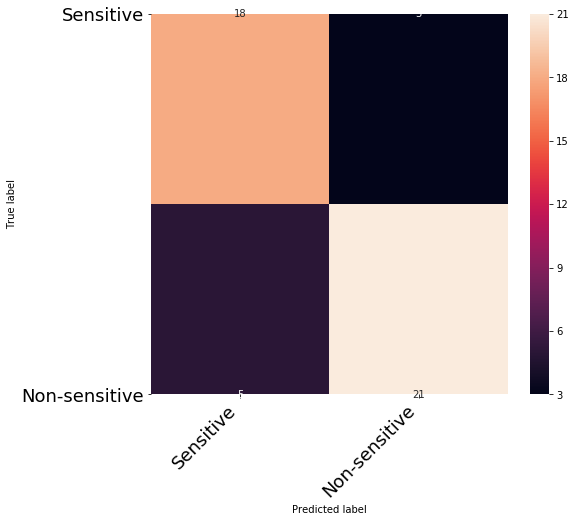

In [39]:
print_confusion_matrix(confusion_matrix, class_names, figsize = (8,7), fontsize=18);

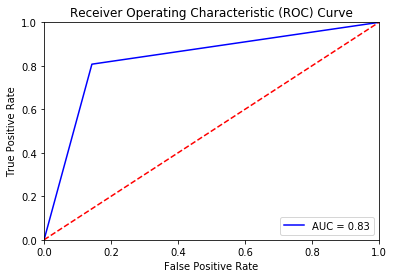

In [40]:
# Create an ROC Curve 
import sklearn.metrics as metrics

fpr, tpr, threshold = metrics.roc_curve(prediction_label_panda['label'], prediction_label_panda['prediction'])
roc_auc = metrics.auc(fpr, tpr)

# method I: plt
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()